<a href="https://colab.research.google.com/github/ElektrosStulpas/QuantumRNN-BachelorsVU/blob/main/QRNNimplementationEightDayGradEverySample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and import needed libraries

In [10]:
!pip install qiskit[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from google.colab import drive
import pandas as pd
import os
import yfinance as yf
import random
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
import numpy as np
import matplotlib.pyplot as plt

Interaction with google drive and loading stock data

In [12]:
def connect_google_drive():
  drive.mount('/content/drive')

def save_and_disconnect_google_drive():
  drive.flush_and_unmount()

In [13]:
stock_data_csv = 'duomenys_yahoo_SPY_20220424.csv'
ROOT_PATH = "/content/drive/MyDrive/QRNNData"

def load_stock_data_from_drive(data_file_name):
  data_frame = pd.read_csv(os.path.join(ROOT_PATH, data_file_name))
  return data_frame

def load_stock_data_from_yahoo_finance(ticker, interval="1d", period="1y"):
  data_frame = yf.download(ticker, period=period, interval=interval)
  return data_frame

In [14]:
#Functions to save and load params (np.array) from and to drive
def save_params_to_drive(file_name, params):
  np.save(os.path.join(ROOT_PATH, file_name), params)

def load_params_from_drive(file_name):
  return np.load(os.path.join(ROOT_PATH, file_name))

In [15]:
connect_google_drive()

Mounted at /content/drive


In [16]:
MSFT_data = load_stock_data_from_yahoo_finance("MSFT")
MSFT_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-11,265.679993,271.359985,259.299988,260.549988,258.018738,48975900
2022-05-12,257.690002,259.880005,250.020004,255.350006,252.869278,51033800
2022-05-13,257.350006,263.040009,255.350006,261.119995,258.583191,34925100
2022-05-16,259.959991,265.820007,255.779999,261.500000,258.959534,32550900
2022-05-17,266.109985,268.329987,262.459991,266.820007,264.227844,28828800


In [17]:
SPY_data = load_stock_data_from_yahoo_finance("SPY")
SPY_data.head()
SPY_data[:10]

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-11,398.070007,404.040009,391.959991,392.750000,386.206696,142361000
2022-05-12,389.369995,395.799988,385.149994,392.339996,385.803528,125090800
2022-05-13,396.709991,403.179993,395.609985,401.720001,395.027252,104174400
2022-05-16,399.980011,403.970001,397.600006,400.089996,393.424438,78622400
2022-05-17,406.529999,408.570007,402.579987,408.320007,401.517334,83029700
2022-05-18,403.500000,403.799988,390.549988,391.859985,385.331512,117674500
2022-05-19,388.619995,394.140015,387.109985,389.459991,382.971497,98510700
2022-05-20,393.250000,397.029999,380.540009,389.630005,383.138672,131432200
2022-05-23,392.829987,397.730011,390.380005,396.920013,390.307251,76414900


In [18]:
spy_data = load_stock_data_from_drive(stock_data_csv)
spy_data.index = spy_data["Date"]
spy_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2017-04-24,2017-04-24,237.179993,237.410004,234.559998,237.169998,217.335434,119209900
2017-04-25,2017-04-25,237.910004,238.949997,237.809998,238.550003,218.600037,76698300
2017-04-26,2017-04-26,238.509995,239.529999,238.350006,238.399994,218.462555,84702500
2017-04-27,2017-04-27,238.770004,238.949997,237.979996,238.600006,218.645874,57410300
2017-04-28,2017-04-28,238.899994,238.929993,237.929993,238.080002,218.169296,63532800


Data preparation

In [19]:
#data normalization
def rescale_data(data, new_scale_from, new_scale_to):
  #GENERAL NORMALIZATION FORMULA from https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
  rescaled_x = (new_scale_to-new_scale_from) * ((data - DATA_MAXMIN[1]) / ( DATA_MAXMIN[0] - DATA_MAXMIN[1])) + new_scale_from

  return rescaled_x

In [20]:
def calculate_data_range(data_array):
  return max(data_array), min(data_array)

def generate_datasets(df_column, train_len, valid_len, sequence_size=7):
  valid_len = train_len + valid_len # since valid len is used as the upper bound

  inputs_TRAIN = rescale_data(df_column, -1, 1)[:train_len]
  # inputs_TRAIN = df_column[:train_len]
  labels_TRAIN = df_column[:train_len+1] # taking one more to include one value past the end so we can naturally shift it without losing length

  inputs_VALID = rescale_data(df_column, -1, 1)[train_len:valid_len]
  labels_VALID = df_column[train_len:valid_len+1] # taking one more to lengthen the array so we can naturally shift it without losing length

  valid_index = labels_VALID.index # save index for plotting data later

  inputs_TRAIN = np.array([inputs_TRAIN[i:i+sequence_size] for i in range(len(inputs_TRAIN) - sequence_size+1)])
  labels_TRAIN = np.array(labels_TRAIN[sequence_size:]) # sequence_size shifts the data naturally
  training_data = list(zip(inputs_TRAIN, labels_TRAIN))

  inputs_VALID = np.array([inputs_VALID[i:i+sequence_size] for i in range(len(inputs_VALID) - sequence_size+1)])
  labels_VALID = np.array(labels_VALID[sequence_size:]) # sequence_size shifts the data naturally
  validation_data = list(zip(inputs_VALID, labels_VALID))

  return training_data, validation_data, valid_index

In [21]:
#CAN CHANGE DATA INPUT HERE
stock_data = SPY_data["Close"]

DATA_MAXMIN = calculate_data_range(stock_data)

# In the work we're following they mention using 100 data points for training and 80 for test
train_dataset, valid_dataset, valid_index = generate_datasets(stock_data, train_len=100, valid_len=80)

SAMPLE_NUM_TRAIN = len(train_dataset)
SAMPLE_NUM_VALID = len(valid_dataset)

In [22]:
for input, label in train_dataset[:4]:
  print(f"{input} {label}")

[-0.01039116 -0.02160264  0.23489184  0.19031966  0.41536777 -0.03472845
 -0.10035583] 389.6300048828125
[-0.02160264  0.23489184  0.19031966  0.41536777 -0.03472845 -0.10035583
 -0.09570684] 396.9200134277344
[ 0.23489184  0.19031966  0.41536777 -0.03472845 -0.10035583 -0.09570684
  0.10363707] 393.8900146484375
[ 0.19031966  0.41536777 -0.03472845 -0.10035583 -0.09570684  0.10363707
  0.02078232] 397.3699951171875


In [23]:
for input, label in valid_dataset[:4]:
  print(f"{input} {label}")

[-0.41454746 -0.43861103 -0.54498192 -0.82964152 -0.90538718 -0.96773332
 -1.        ] 365.9700012207031
[-0.43861103 -0.54498192 -0.82964152 -0.90538718 -0.96773332 -1.
 -0.74268521] 357.6300048828125
[-0.54498192 -0.82964152 -0.90538718 -0.96773332 -1.         -0.74268521
 -0.97074085] 366.82000732421875
[-0.82964152 -0.90538718 -0.96773332 -1.         -0.74268521 -0.97074085
 -0.71944195] 371.1300048828125


In [24]:
print(f"train_dataset len: {len(train_dataset)}, valid_dataset len: {len(valid_dataset)}")

train_dataset len: 94, valid_dataset len: 74


Model

In [25]:
from enum import Enum

class ModelType(Enum):
  PLAIN = 1
  STAG = 2

In [26]:
class QRNN():
  def __init__(self, q_reg, params):
    self.qubits_per_reg = q_reg

    if params is not None:
      self.params = params
    else:
       self.params = self.init_random_params()

    self.ansatz = self.construct_ansatz()


  def set_params(self, params):
    self.params = params
    self.ansatz = self.construct_ansatz()

  def get_params(self):
    return self.params


  def construct_enc_circ(self, x_val):
    enc_circ = QuantumCircuit(self.qubits_per_reg)

    for qubit in range(self.qubits_per_reg):
      enc_circ.ry(np.arccos(x_val), qubit)

    return enc_circ


  def construct_ansatz(self):
    theta_gamma_params = self.params

    ansatz = QuantumCircuit(self.qubits_per_reg*2)

    qu_indexes = list(range(self.qubits_per_reg*2))
    qu_indexes_rolled = list(range(1, self.qubits_per_reg*2))
    qu_indexes_rolled.append(0)

    for idx in qu_indexes:
      ansatz.rx(theta_gamma_params[idx][0], idx)
      ansatz.rz(theta_gamma_params[idx][1], idx)
      ansatz.rx(theta_gamma_params[idx][2], idx)

    for idx in qu_indexes:
      ansatz.cnot(idx, qu_indexes_rolled[idx])
      ansatz.rz(theta_gamma_params[idx][3], qu_indexes_rolled[idx])
      ansatz.cnot(idx, qu_indexes_rolled[idx])

    return ansatz


  def partial_trace_measure(self, circuit, qubit_to_measure):
    circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)
    qubits_to_trace_out = list(range(self.qubits_per_reg*2))
    qubits_to_trace_out.remove(qubit_to_measure)

    measured_qubit_rho = qi.partial_trace(circ_dens_matrix, qubits_to_trace_out)

    ket1 = qi.Statevector([0, 1])
    projector1 = ket1.to_operator()

    trimmed_measured_qubit_rho = measured_qubit_rho.evolve(projector1)
    prediction_y = trimmed_measured_qubit_rho.trace()

    return prediction_y
    

  def init_random_params(self):
    rng = np.random.default_rng()
    theta_gamma_params = np.arccos(rng.uniform(-1, 1, size=(self.qubits_per_reg*2, 4))) #6x3 theta params and 6x1 gamma params
    return theta_gamma_params

In [27]:
class pQRNN(QRNN):
  def __init__(self, q_reg=3, params=None):
    super().__init__(q_reg, params)
    self.model_type = ModelType.PLAIN


  def get_model_type(self):
    return self.model_type


  #takes input vector of value from -1 to 1, outputs prediction in range 0 to 1
  def forward(self, x_vec):
    QRNN_circuit = QuantumCircuit(self.qubits_per_reg*2)

    QRNN_circuit.reset(list(range(self.qubits_per_reg*2)))

    for idx in range(7):
      QRNN_circuit.reset(list(range(self.qubits_per_reg)))
      encoding_circ = self.construct_enc_circ(x_vec[idx])
      QRNN_circuit.compose(encoding_circ, list(range(self.qubits_per_reg)), inplace=True)

      QRNN_circuit.compose(self.ansatz, inplace=True, wrap=True)

    y_t = self.partial_trace_measure(QRNN_circuit, 1)

    return abs(y_t) # don't need to square this because the probability comes from the density matrix, which already holds squared values


In [31]:
class sQRNN(QRNN):
  def __init__(self, q_reg=3, params=None):
    super().__init__(q_reg, params)
    self.model_type = ModelType.STAG

  def get_model_type(self):
    return self.model_type

  #takes input vector of value from -1 to 1, outputs prediction in range 0 to 1
  def forward(self, x_vec):
    QRNN_circuit = QuantumCircuit(self.qubits_per_reg*2)

    QRNN_circuit.reset(list(range(self.qubits_per_reg*2)))

    measure_qubit = None

    for idx in range(7):
      reg_d_list = [(idx+i)%(self.qubits_per_reg*2) for i in range(self.qubits_per_reg)]
      measure_qubit = reg_d_list[1]

      QRNN_circuit.reset(reg_d_list)
      encoding_circ = self.construct_enc_circ(x_vec[idx])
      QRNN_circuit.compose(encoding_circ, reg_d_list, inplace=True)

      QRNN_circuit.compose(self.ansatz, inplace=True, wrap=True)

    y_t = self.partial_trace_measure(QRNN_circuit, measure_qubit)

    return abs(y_t)# don't need to square this because the probability comes from the density matrix, which already holds squared values


In [ ]:
# class CasQRNN(QRNN):
#   def __init__(self, q_reg=3, params=None):
#     super().__init__(q_reg, params)
#     self.model_type = ModelType.STAG_CAS


#   def get_model_type(self):
#     return self.model_type


  # #takes input vector of value from -1 to 1, outputs prediction in range 0 to 1
  # def forward(self, x_vec):
  #   QRNN_circuit = QuantumCircuit(self.qubits_per_reg*2)

  #   QRNN_circuit.reset(list(range(self.qubits_per_reg*2)))

  #   qubit_to_measure = None
  #   going_down = True
  #   reg_d_center = 0

  #   for idx in range(7):

  #     reg_d_center = (idx % (self.qubits_per_reg+1)) + 1

  #     qubit_to_measure = reg_d_center
  #     reg_d_list = list(range(reg_d_center-1, reg_d_center + self.qubits_per_reg-1))

  #     QRNN_circuit.reset(reg_d_list)
  #     encoding_circ = self.construct_enc_circ(x_vec[idx])
  #     QRNN_circuit.compose(encoding_circ, reg_d_list, inplace=True)

  #     QRNN_circuit.compose(self.ansatz, inplace=True, wrap=True)

  #   y_t = self.partial_trace_measure(QRNN_circuit, qubit_to_measure)

  #   return abs(y_t)# don't need to square this because the probability comes from the density matrix, which already holds squared values


In [ ]:
# class BounsQRNN(QRNN):
#   def __init__(self, q_reg=3, params=None):
#     super().__init__(q_reg, params)
#     self.model_type = ModelType.STAG_BOUNS


#   def get_model_type(self):
#     return self.model_type


#   #takes input vector of value from -1 to 1, outputs prediction in range 0 to 1
#   def forward(self, x_vec):
#     QRNN_circuit = QuantumCircuit(self.qubits_per_reg*2)

#     QRNN_circuit.reset(list(range(self.qubits_per_reg*2)))

#     qubit_to_measure = None
#     going_down = True
#     reg_d_center = 0

#     for idx in range(7):

#       if going_down:
#         reg_d_center += 1
#         if reg_d_center == self.qubits_per_reg + 1:
#           going_down = not going_down
#       else:
#         reg_d_center -= 1
#         if reg_d_center == 1:
#           going_down = not going_down
      
#       qubit_to_measure = reg_d_center
#       reg_d_list = list(range(reg_d_center-1, reg_d_center + self.qubits_per_reg-1))

#       QRNN_circuit.reset(reg_d_list)
#       encoding_circ = self.construct_enc_circ(x_vec[idx])
#       QRNN_circuit.compose(encoding_circ, reg_d_list, inplace=True)

#       QRNN_circuit.compose(self.ansatz, inplace=True, wrap=True)

#     y_t = self.partial_trace_measure(QRNN_circuit, qubit_to_measure)

#     return abs(y_t)# don't need to square this because the probability comes from the density matrix, which already holds squared values


In [ ]:
# model = sQRNN_ALT()
# circuit = None

# for input, label in train_dataset[:4]:
#   print(f"{input} {label}")
#   pred, circuit = model.forward(input)

# circuit.draw('mpl')

In [ ]:
# generating random params and saving it to be reused so it would be easier to measure performance with different hyper-parameters

# model = QRNN()
# save_params_to_drive(root_path, "6_qubit_params", model.get_params())

Sanity check that the ansatz gets assigned the correct values

In [ ]:
qubit_num = 6
rng = np.random.default_rng()
theta_gamma_params = np.arccos(rng.uniform(-1, 1, size=(qubit_num, 4)))

print(theta_gamma_params)

qu_indexes = list(range(qubit_num))
qu_indexes_rolled = list(range(1, qubit_num))
qu_indexes_rolled.append(0)

for idx in qu_indexes:
  print(f"RX: {theta_gamma_params[idx][0]}, RZ: {theta_gamma_params[idx][1]}, RX: {theta_gamma_params[idx][2]} for qubit {idx}")

for idx in qu_indexes:
  print(f"RZ: {theta_gamma_params[idx][3]} gamma on qubit {qu_indexes_rolled[idx]}")

[[2.41779654 0.2951661  1.41694503 2.14216498]
 [1.63834681 1.19231047 0.74437842 1.00450887]
 [1.08143589 1.43263832 0.40147297 1.32377744]
 [1.02470047 2.69304046 1.72704184 2.30256395]
 [1.90391565 0.74908832 0.99245182 1.75181152]
 [1.64804443 1.67521991 1.82591183 0.61280181]]
RX: 2.4177965403339137, RZ: 0.2951661018489961, RX: 1.4169450299867987 for qubit 0
RX: 1.638346810294292, RZ: 1.1923104716592645, RX: 0.7443784248874986 for qubit 1
RX: 1.0814358944235551, RZ: 1.4326383163916776, RX: 0.4014729686079183 for qubit 2
RX: 1.0247004744544472, RZ: 2.6930404598151747, RX: 1.7270418402250827 for qubit 3
RX: 1.9039156504243915, RZ: 0.7490883234464805, RX: 0.9924518221466266 for qubit 4
RX: 1.6480444265708842, RZ: 1.6752199094200488, RX: 1.8259118321653902 for qubit 5
RZ: 2.1421649823101485 gamma on qubit 1
RZ: 1.0045088729459224 gamma on qubit 2
RZ: 1.3237774445035357 gamma on qubit 3
RZ: 2.3025639464778176 gamma on qubit 4
RZ: 1.751811521920038 gamma on qubit 5
RZ: 0.612801811582687

TRAINING

In [ ]:
def L2_loss(prediction, true_val, sample_num):
  loss = ((prediction-true_val)**2) / sample_num
  return loss

In [ ]:
def prediction_accuracy(predicted, actual):
  E_vec = (actual-predicted) / actual

  # Alternative accuracy formula
  # accuracy = (1 - np.mean(abs(E_vec))) * 100

  #This accuracy formula is presented in the work
  accuracy = (1-np.mean(E_vec**2)**0.5) * 100
  return accuracy

In [ ]:
def postprocess_output(output):
  return output * (DATA_MAXMIN[0]-DATA_MAXMIN[1]) + DATA_MAXMIN[1]

In [ ]:
def gradient_descent(model_type, params, input, label, perturbation=0.001, lr=0.03):
  params_1d = np.reshape(params, -1)
  len_params = len(params_1d)
  gradients = np.zeros(len_params)

  #for every parameter
  for idx in range(len_params):
    #generate index vector
    e_vec = np.zeros(len_params)
    e_vec[idx] = 1

    #generate params with finite diff to both sides
    params_1d_plus = params_1d + perturbation*e_vec
    params_plus = np.reshape(params_1d_plus, params.shape)
    params_1d_minus = params_1d - perturbation*e_vec
    params_minus = np.reshape(params_1d_minus, params.shape)

    #create QRNNs with the finite difference params
    if model_type == ModelType.PLAIN:
      QRNN_plus = pQRNN(params=params_plus)
      QRNN_minus = pQRNN(params=params_minus)
    elif model_type == ModelType.STAG:
      QRNN_plus = sQRNN(params=params_plus)
      QRNN_minus = sQRNN(params=params_minus)
    else:
      print(f"Unknown model type: {model_type}")

    # run forward pass to get predictions 
    prediction_plus = postprocess_output(QRNN_plus.forward(input))
    prediction_minus = postprocess_output(QRNN_minus.forward(input))

    # calculate gradient for this parameter
    gradients[idx] = (L2_loss(prediction_plus, label, SAMPLE_NUM_TRAIN)-L2_loss(prediction_minus, label, SAMPLE_NUM_TRAIN)) / (2*perturbation)

  #apply gradients to parameters and return the updated parameters
  params_1d = params_1d - gradients*lr

  return np.reshape(params_1d, params.shape)


In [ ]:
def after_epoch_validation(model, validation_data):

  # random.shuffle(validation_data)
  losses = []
  predictions = []
  labels = []

  for input, label in validation_data:
    labels.append(label)

    prediction = postprocess_output(model.forward(input))
    predictions.append(prediction)

    loss = L2_loss(prediction, label, SAMPLE_NUM_VALID)
    losses.append(loss)

  avg_loss = np.mean(losses)
  accuracy = prediction_accuracy(np.array(predictions), np.array(labels))

  print(f"Validation loss: {avg_loss:.2f}, validation accuracy: {accuracy:.2f}")

  return np.array(predictions), np.array(labels)

In [ ]:
def training(model, training_data, validation_data, epochs_num):

  predictions_and_labels_epochs = []

  for epoch in range(epochs_num):
    # random.shuffle(training_data)
    losses = []
    predictions = []
    labels = []

    for input, label in training_data:
      labels.append(label)

      prediction = model.forward(input)
      prediction = postprocess_output(prediction)

      predictions.append(prediction)

      loss = L2_loss(prediction, label, SAMPLE_NUM_TRAIN)
      losses.append(loss)

      updated_params = gradient_descent(model.get_model_type(), model.get_params(), input, label)
      model.set_params(updated_params)

      if len(losses)%5 == 0:
        print(f"Average running loss: {np.mean(losses):.2f} Average running accuracy: {prediction_accuracy(np.array(predictions), np.array(labels)):.2f}")
        print("=====================================")

    avg_loss = np.mean(losses)
    accuracy = prediction_accuracy(np.array(predictions), np.array(labels))
    print(f"\nEpoch {epoch+1} / {epochs_num}: Loss = {avg_loss:.2f}, Accuracy: {accuracy:.2f}\n")

    predictions_and_labels_epochs.append((predictions, labels))

    # after_epoch_validation(model, validation_data)

  return model, np.array(predictions_and_labels_epochs)



TRAINING the model

In [ ]:
loaded_params = load_params_from_drive("6_qubit_params.npy")
print(loaded_params)

[[1.71844876 2.04838708 1.65311667 0.46461651]
 [1.12144523 1.17159783 1.71884063 1.26738357]
 [0.91594512 1.86570833 1.94842573 0.57828036]
 [1.17263427 2.53478912 1.10382683 1.90555317]
 [1.43265092 0.9580048  1.75344986 1.34060377]
 [0.98705363 0.61479902 1.85558472 0.53640413]]


In [ ]:
trained_model_sQRNN, epochs_training_progress_sQRNN = training(sQRNN(params=loaded_params), train_dataset, valid_dataset, 1)

Average running loss: 1.99 Average running accuracy: 96.51
Average running loss: 2.18 Average running accuracy: 96.45
Average running loss: 1.49 Average running accuracy: 97.06
Average running loss: 2.89 Average running accuracy: 95.75
Average running loss: 2.50 Average running accuracy: 96.03
Average running loss: 2.16 Average running accuracy: 96.31
Average running loss: 1.86 Average running accuracy: 96.57
Average running loss: 1.65 Average running accuracy: 96.77
Average running loss: 1.51 Average running accuracy: 96.92
Average running loss: 1.44 Average running accuracy: 97.00
Average running loss: 1.33 Average running accuracy: 97.12
Average running loss: 1.24 Average running accuracy: 97.22
Average running loss: 1.15 Average running accuracy: 97.32
Average running loss: 1.13 Average running accuracy: 97.36
Average running loss: 1.06 Average running accuracy: 97.44
Average running loss: 1.01 Average running accuracy: 97.50
Average running loss: 1.00 Average running accuracy: 97.

In [ ]:
trained_model_pQRNN, epochs_training_progress_pQRNN = training(pQRNN(params=loaded_params), train_dataset, valid_dataset, 1)

# save_params_to_drive("001pert_03lr_no_shuffle1epochSPY", trained_model.get_params())

Average running loss: 5.40 Average running accuracy: 94.24
Average running loss: 3.47 Average running accuracy: 95.44
Average running loss: 2.35 Average running accuracy: 96.25
Average running loss: 3.47 Average running accuracy: 95.34
Average running loss: 3.01 Average running accuracy: 95.65
Average running loss: 2.76 Average running accuracy: 95.83
Average running loss: 2.41 Average running accuracy: 96.10
Average running loss: 2.16 Average running accuracy: 96.31
Average running loss: 2.06 Average running accuracy: 96.41
Average running loss: 2.02 Average running accuracy: 96.46
Average running loss: 1.95 Average running accuracy: 96.53
Average running loss: 1.85 Average running accuracy: 96.62
Average running loss: 1.72 Average running accuracy: 96.75
Average running loss: 1.64 Average running accuracy: 96.83
Average running loss: 1.53 Average running accuracy: 96.93
Average running loss: 1.46 Average running accuracy: 97.01
Average running loss: 1.41 Average running accuracy: 97.

In [ ]:
valid_predictions_sQRNN, valid_labels_sQRNN = after_epoch_validation(trained_model_sQRNN, valid_dataset)

Validation loss: 0.87, validation accuracy: 97.96


In [ ]:
valid_predictions_pQRNN, valid_labels_pQRNN = after_epoch_validation(trained_model_pQRNN, valid_dataset)

Validation loss: 0.61, validation accuracy: 98.28


PLOT TRAINING PROGRESS

In [ ]:
# def plot_predictions_and_labels(predictions_and_labels_array, title):
#   for predictions_and_labels in predictions_and_labels_array:
#     predictions, labels = predictions_and_labels

#     plt.figure(figsize=(12, 5))
#     plt.plot(predictions)
#     plt.plot(labels)
#     plt.title(f"{title}")
#     plt.ylabel("Closing price")
#     plt.xlabel("Dates")
#     plt.xticks(rotation=65)
#     plt.grid()
#     plt.show()

def plot_predictions_and_labels(predictions, labels, title=""):
  plt.figure(figsize=(18, 5))
  plt.plot(predictions)
  plt.plot(labels)
  plt.title(f"{title}")
  plt.ylabel("Closing price")
  plt.xlabel("Dates")
  plt.xticks(rotation=65)
  plt.grid()
  plt.show() 

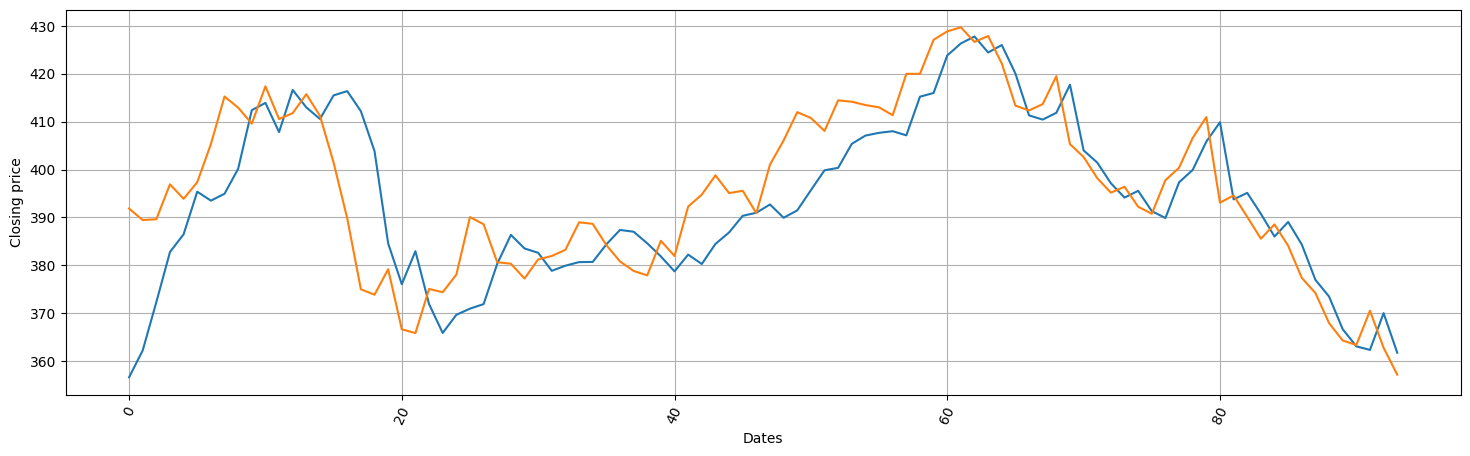

In [ ]:
for training_progr in epochs_training_progress_pQRNN:
  epochsDF = pd.DataFrame(training_progr.T, columns=['Predictions', 'Labels'])
  plot_predictions_and_labels(epochsDF['Predictions'], epochsDF['Labels'])

# labels_Train = np.array(labels_TRAIN)
# epochsDF = epochsDF.assign(Labels=np.reshape(labels_Train, -1))

# epochsDF.index = spy_data.Date[1:len(epochsDF.Labels)+1]

PLOT VALIDATION PROGRESS

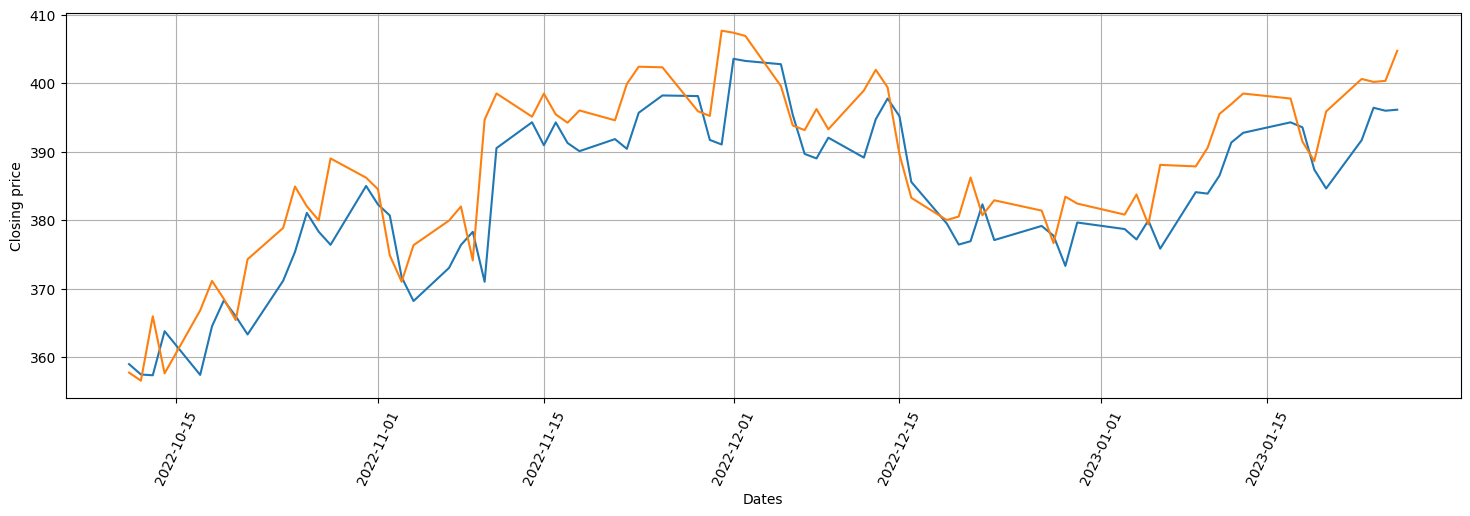

In [ ]:
validDF = pd.DataFrame({'Predictions': valid_predictions_pQRNN, 'Labels': valid_labels_pQRNN})
validDF.index = valid_index[7:]
plot_predictions_and_labels(validDF['Predictions'], validDF['Labels'])

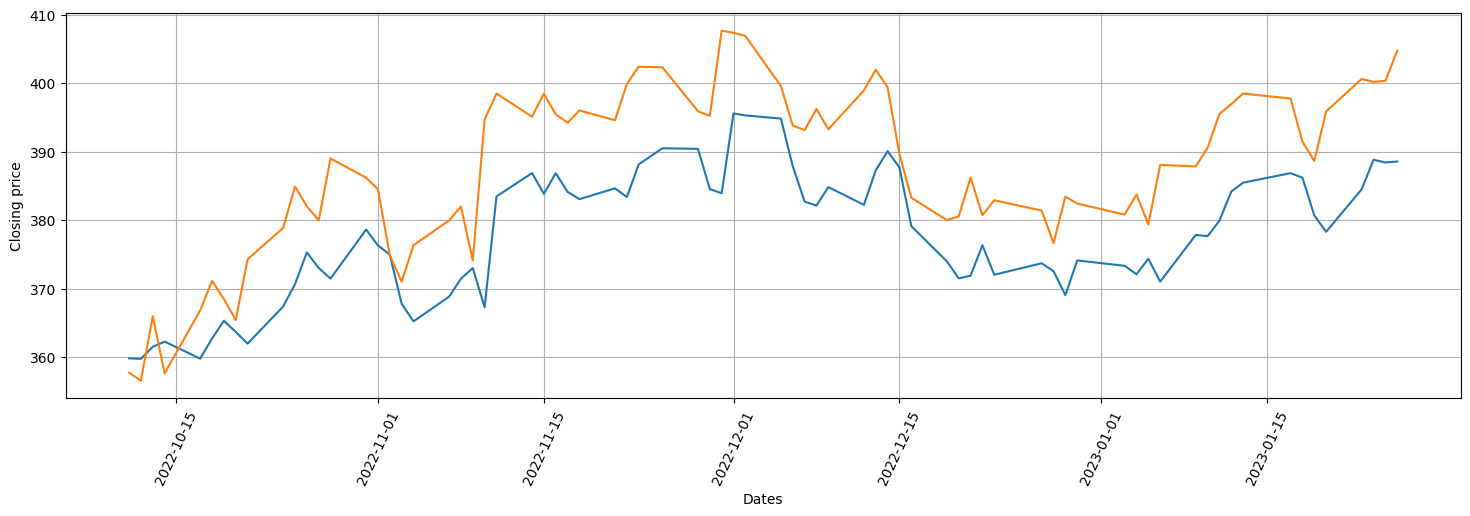

,Predictions,Labels
Date,,
2022-10-11,359.820043,357.739990
2022-10-12,359.750711,356.559998
2022-10-13,361.507221,365.970001
2022-10-14,362.264552,357.630005
2022-10-17,359.786163,366.820007


In [ ]:
validDF = pd.DataFrame({'Predictions': valid_predictions_sQRNN, 'Labels': valid_labels_sQRNN})
validDF.index = valid_index[7:]
plot_predictions_and_labels(validDF['Predictions'], validDF['Labels'])

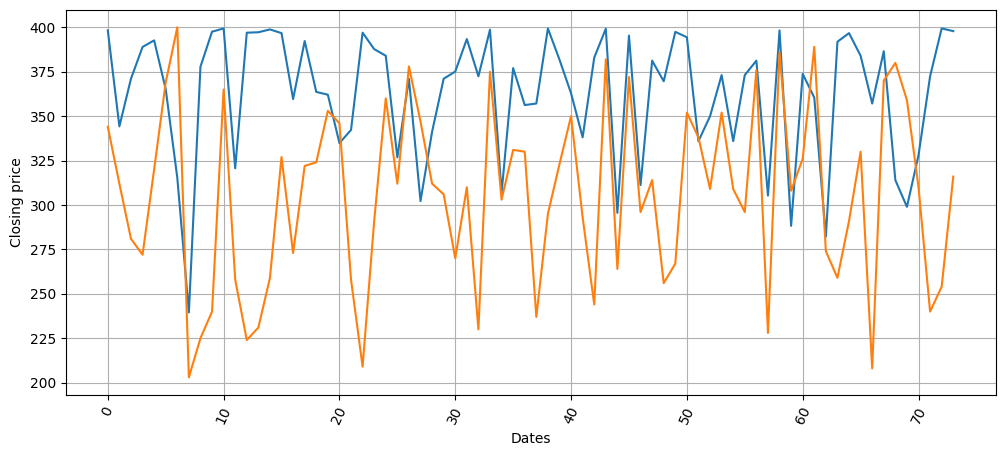

In [ ]:
plot_predictions_and_labels(validDF.T[0], validDF.T[1])

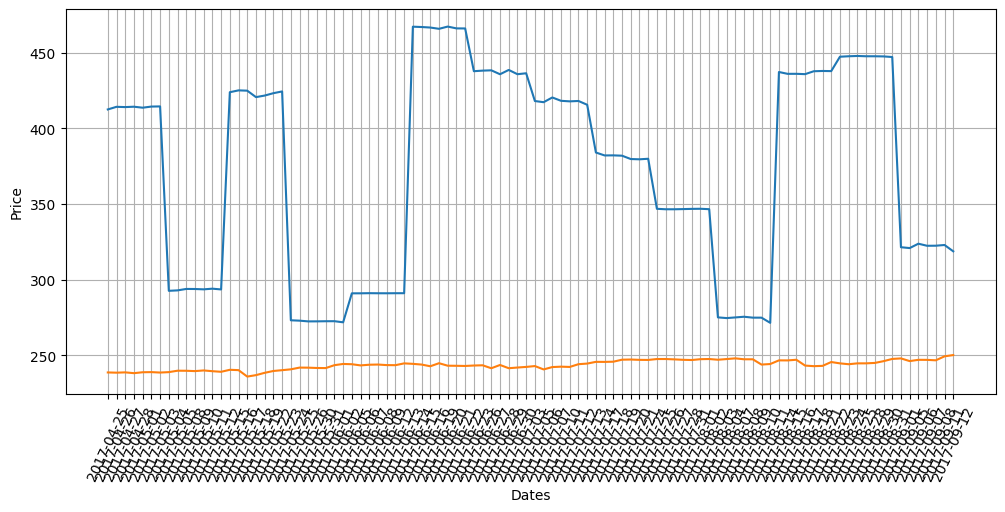

In [ ]:
plot_array(epochsDF[1], epochsDF["Labels"])

Could try normalizing params to 0-pi range, since now they seem to be way over the 0-3.14 rad radius after gradients are applied

print out average predictions and average labels to see if they're converging at all

VALIDATION (inference)

In [ ]:
print(inputs_VALID[:5])

[[-0.78693673 -0.79400215 -0.78984138 -0.78787875 -0.78717223 -0.79243207
  -0.79203952]
 [-0.79400215 -0.78984138 -0.78787875 -0.78717223 -0.79243207 -0.79203952
  -0.79604336]
 [-0.78984138 -0.78787875 -0.78717223 -0.79243207 -0.79203952 -0.79604336
  -0.79486571]
 [-0.78787875 -0.78717223 -0.79243207 -0.79203952 -0.79604336 -0.79486571
  -0.78725069]
 [-0.78717223 -0.79243207 -0.79203952 -0.79604336 -0.79486571 -0.78725069
  -0.78489551]]


In [ ]:
labels_VALID[157]

263.190002

In [ ]:
def inference(model, seven_day_vec, maxmin):
  print(f"Seven day data: {seven_day_vec}")

  prediction = postprocess_output(model.forward(seven_day_vec), maxmin[0], maxmin[1])
  
  print(f"Prediction for the eight day: {prediction}")

  return prediction

In [ ]:
output = inference(trained_model, inputs_VALID[50], data_maxmin)

Seven day data: [-0.70631191 -0.70733227 -0.68660701 -0.68786313 -0.66980677 -0.67412471
 -0.67663669]
Prediction for the eight day: 259.52790489735946


In [ ]:
params_1d = np.reshape(theta_gamma_params, -1)
e_vec = np.zeros(len(params_1d))
e_vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [ ]:
theta_gamma_params

array([[0.88220813, 1.05991204, 1.46680408, 2.15098491],
       [2.90851839, 1.03002548, 1.72818114, 2.30659077],
       [0.39394578, 2.09449693, 1.2806631 , 2.33098704],
       [1.79428738, 1.14440894, 1.56955949, 2.6666867 ],
       [1.69497222, 1.01184316, 1.28220669, 1.50586418],
       [2.42397432, 1.25885186, 1.23701419, 1.7539721 ]])

In [ ]:
np.reshape(params_1d, (6, 4))

array([[0.88220813, 1.05991204, 1.46680408, 2.15098491],
       [2.90851839, 1.03002548, 1.72818114, 2.30659077],
       [0.39394578, 2.09449693, 1.2806631 , 2.33098704],
       [1.79428738, 1.14440894, 1.56955949, 2.6666867 ],
       [1.69497222, 1.01184316, 1.28220669, 1.50586418],
       [2.42397432, 1.25885186, 1.23701419, 1.7539721 ]])

In [ ]:
params = np.array([[1, 2, 3],[4, 5, 6]])

gradient_descent(params, 0)

[[1 2 3]
 [4 5 6]]
[1.001 2.    3.    4.    5.    6.   ]
[0.999 2.    3.    4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.001 3.    4.    5.    6.   ]
[1.    1.999 3.    4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.001 4.    5.    6.   ]
[1.    2.    2.999 4.    5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.001 5.    6.   ]
[1.    2.    3.    3.999 5.    6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.    5.001 6.   ]
[1.    2.    3.    4.    4.999 6.   ]
[1 2 3 4 5 6]
[1.    2.    3.    4.    5.    6.001]
[1.    2.    3.    4.    5.    5.999]
[1 2 3 4 5 6]


In [ ]:
QRNN_model = QRNN()
qc, model = QRNN_model.forward(inputs)

In [ ]:
qc

array([-0.25984296, -0.19762551, -0.23026206, -0.02800841, -0.12198073,
        0.2522841 ,  0.10216996])

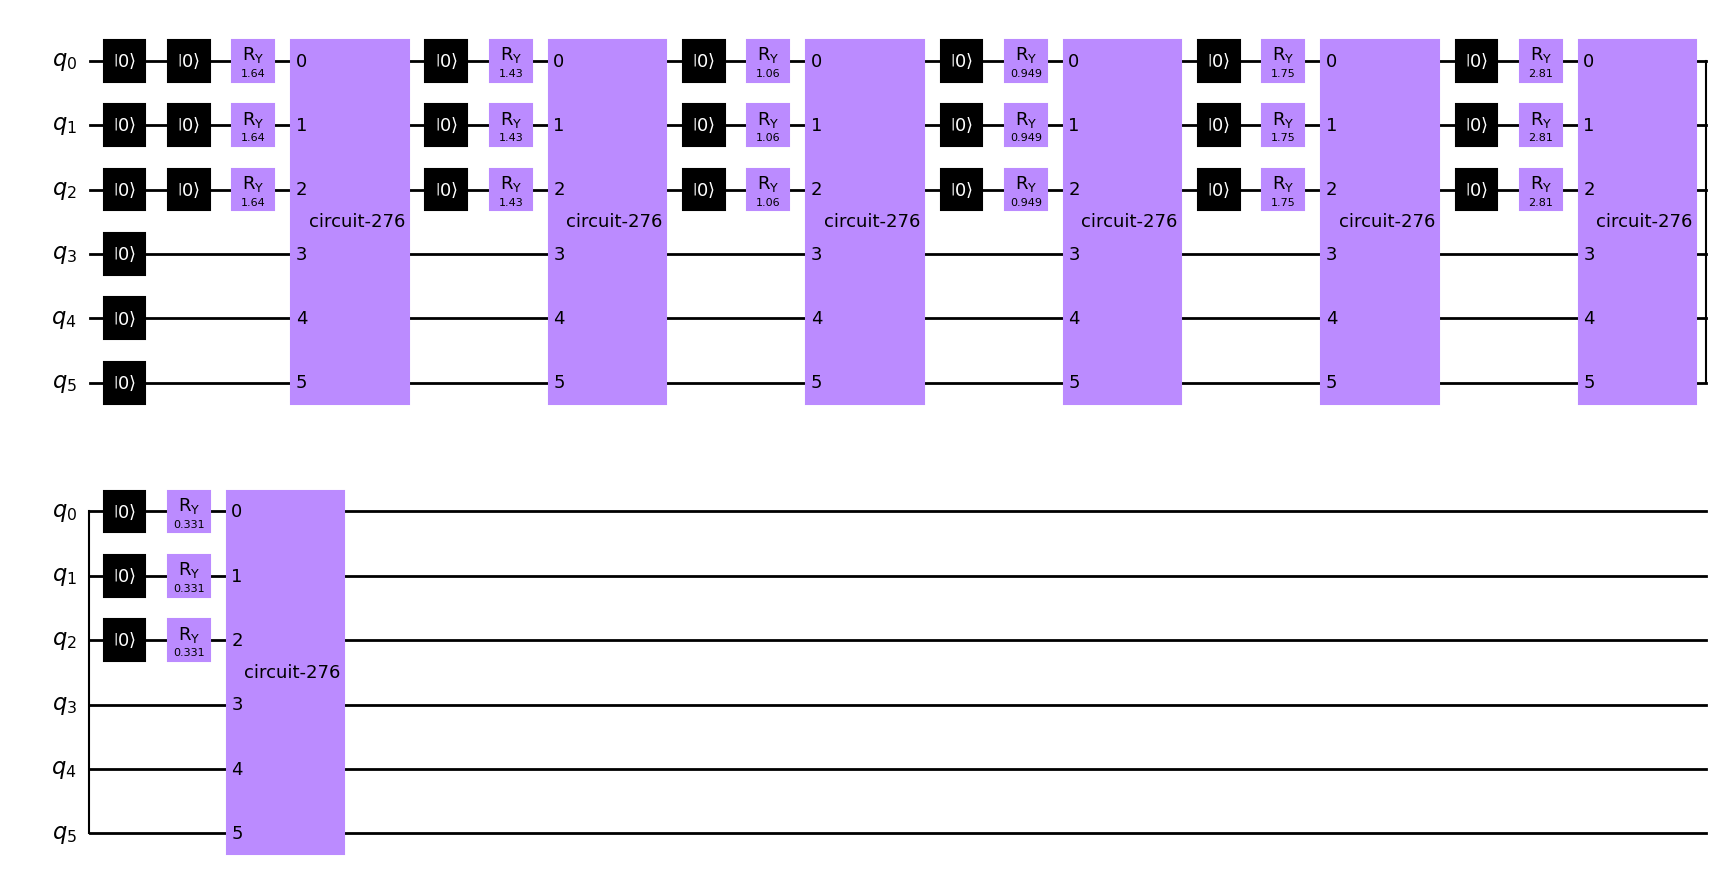

In [ ]:
model.draw("mpl")

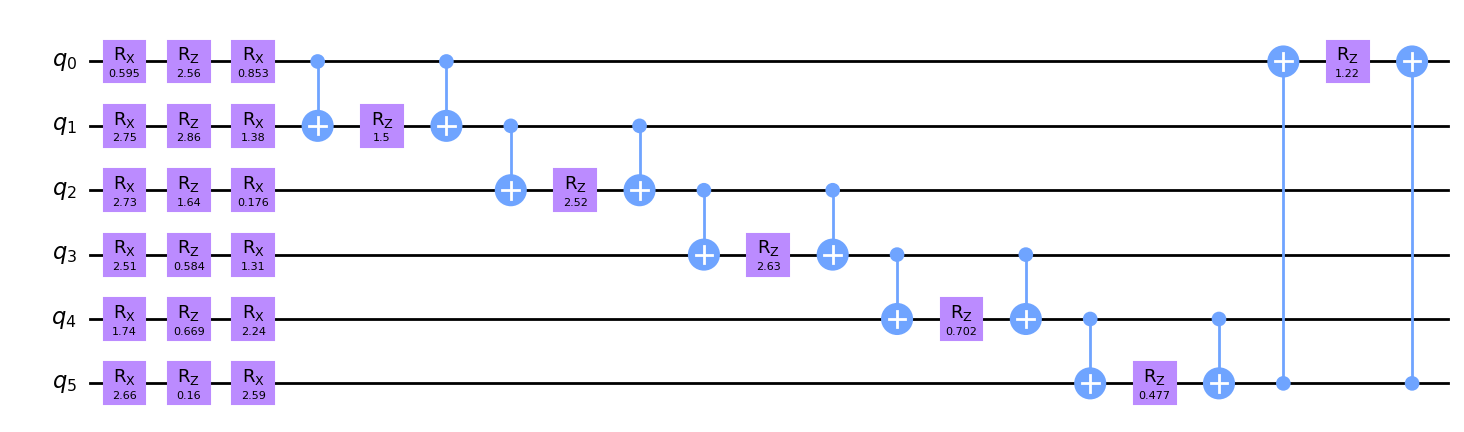

In [ ]:
ans = QRNN_model.construct_ansatz()
ans.draw("mpl")

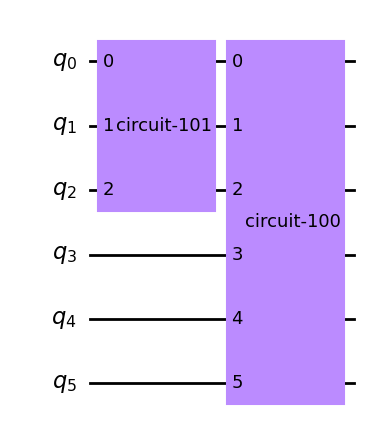

In [ ]:
qc.draw('mpl')

In [ ]:
# x = 128.54
x = np.array([1, 3, 4, 5, -1, -7])
# goal : range [0, 1]
#NORMALIZATION FORMULA from https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
x1 = ((x - min(x)) / ( max(x) - min(x)))*2-1
print(x1)
# math.acos(x)
# print(math.acos(x))

# print(math.acos(0.55))


[ 0.33333333  0.66666667  0.83333333  1.          0.         -1.        ]


In [ ]:
rng = np.random.default_rng()
weights = rng.uniform(-1, 1, size=(6, 3))

In [ ]:
weights[]

array([[-0.68669286, -0.59068147, -0.94100421],
       [-0.52644754,  0.58167242, -0.14022919],
       [ 0.19528282,  0.08767172, -0.97406722],
       [-0.29248123,  0.09339544,  0.51187105],
       [-0.70119153,  0.19938807,  0.96372905],
       [-0.93182738,  0.55379874,  0.73056861]])

In [ ]:
weights[0][0]

-0.6866928594082833

In [ ]:
gamma_params = np.arccos(rng.uniform(-1, 1, size=(6, 1)))

In [ ]:
gamma_params

array([[2.01756771],
       [2.00816587],
       [2.63754127],
       [1.96501209],
       [2.97102456],
       [2.59263829]])

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


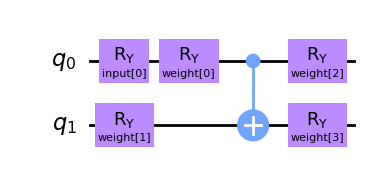

In [ ]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
# qc2.ry(inputs2[1], 1)
# qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

In [ ]:
for idx in list(range(6)):
  print(idx, )

0
1
2
3
4
5


In [ ]:
range_list = list(range(1, 6))

In [ ]:
range_list.append(0)

In [ ]:
new_list = range_list.append(range_list.pop(0))

In [ ]:
range_list

[1, 2, 3, 4, 5, 0]

In [ ]:
new_list

In [ ]:
for idx in range_list:
  print(f"Regular id: {idx}, rolled idx: {range_list[idx]}")

Regular id: 0, rolled idx: 0
Regular id: 1, rolled idx: 1
Regular id: 2, rolled idx: 2
Regular id: 3, rolled idx: 3
Regular id: 4, rolled idx: 4
Regular id: 5, rolled idx: 5


In [ ]:
list(range(3*2))[1:]

[1, 2, 3, 4, 5]

In [ ]:
import numpy as np
from qiskit import *
from qiskit import Aer

backend = Aer.get_backend('unitary_simulator')
#prepare 2qubits
circ = QuantumCircuit(2)
circ.h(1)
circ.ch(1, 0)

job = execute(circ, backend)
result = job.result()
print(result.get_unitary(circ, decimals=3))

Operator([[ 0.707-0.j, -0.   +0.j,  0.707-0.j, -0.   +0.j],
          [ 0.   +0.j,  0.707+0.j,  0.   +0.j,  0.707-0.j],
          [ 0.5  -0.j,  0.5  -0.j, -0.5  +0.j, -0.5  +0.j],
          [ 0.5  +0.j, -0.5  -0.j, -0.5  +0.j,  0.5  -0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [ ]:
circuit = QuantumCircuit(2, 2)

# Add a H gate on qubit 0
# circuit.h(0)
# circuit.h(0)
# circuit.h(1)
# circuit.h(2)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
# circuit.ch(1, 0)

circuit.h(1)

circuit.ch(1, 0)

circuit.draw()

┌───┐
q_0: ─────┤ H ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
c: 2/══════════

In [ ]:
circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)

In [ ]:
circ_dens_matrix

DensityMatrix([[0.5       +0.j, 0.        +0.j, 0.35355339+0.j,
                0.35355339+0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.35355339+0.j, 0.        +0.j, 0.25      +0.j,
                0.25      +0.j],
               [0.35355339+0.j, 0.        +0.j, 0.25      +0.j,
                0.25      +0.j]],
              dims=(2, 2))


In [ ]:
def fun(circuit):
  circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)
  qubits_to_trace_out = list(range(2))[:1]
  print(qubits_to_trace_out)

  measured_qubit_rho = qi.partial_trace(circ_dens_matrix, qubits_to_trace_out)

  ket1 = qi.Statevector([0, 1])
  projector1 = ket1.to_operator()

  trimmed_measured_qubit_rho = measured_qubit_rho.evolve(projector1)
  # return trimmed_measured_qubit_rho.trace()
  return measured_qubit_rho


In [ ]:
dm = fun(circuit)

[0]


In [ ]:
dm

DensityMatrix([[0.5       +0.j, 0.35355339+0.j],
               [0.35355339+0.j, 0.5       +0.j]],
              dims=(2,))


In [ ]:
y_t = fun(circuit)

In [ ]:
abs(y_t)

0.9999999999999993

In [ ]:
# importing "cmath" for complex number operations
import cmath
 
# Initializing real numbers
x = 0.8
y = 0.2
 
# converting x and y into complex number
z = complex(x,y);

In [ ]:
z

(0.8+0.2j)

In [ ]:
abs(z)**2

0.68

In [ ]:
skaiciai = [random.randint(200, 400) for i in range(1000)]